In [7]:
# 필요 라이브러리 설치
!pip install -r requirements.txt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.cluster import KMeans

# functions.py 파일의 함수들 가져오기
from functions import *

### 과제 1 : 수입 분류 문제

수입이 50K 이상인 사람들을 분류해봅시다 !

이번 과제는 Kaggle의 Adult income 데이터셋을 활용하도록 구성되었습니다. (https://www.kaggle.com/datasets/wenruliu/adult-income-dataset)


[데이터 필드 설명]
- `age` -> 나이
- `workclass` -> 직업군
- `fnlwgt` -> 응답자가 조사에서 대표하는 인구 수 
- `education` -> 교육 수준
- `education-num` -> 교육 연수
- `marital-status` -> 결혼 상태
- `occupation` -> 직업
- `Relationship` -> 가족 관계
- `race` -> 인종
- `gender` -> 성별
- `capital-gain` -> 자본 이득
- `capital-loss` -> 자본 손실
- `hours-per-week` -> 주당 근무 시간
- `native-country` -> 출신 국가
- `class` -> 소득 수준 (target variable), 50K 이상 or 미만으로 분류

#### (1) 데이터 확인 및 간단한 전처리

- 원본 데이터의 컬럼 중 native-country, relationship, workclass 열을 제외한 나머지를 x 변수로 사용했습니다.

In [8]:
data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [12]:
X,y = preprocess_adult_data(data)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### (2) 모델 학습 및 성능 평가

In [14]:
# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)

# XGBoost
xgb_model = XGBClassifier(random_state=42)

models = {
    'Decision Tree': tree_model,
    'XGBoost': xgb_model
}


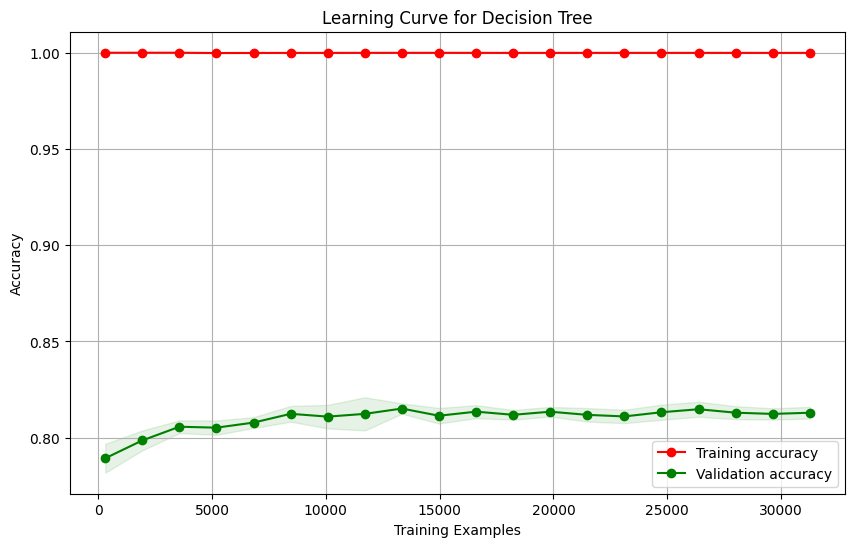

Decision Tree - Training Accuracy: 0.9999, Test Accuracy: 0.8147


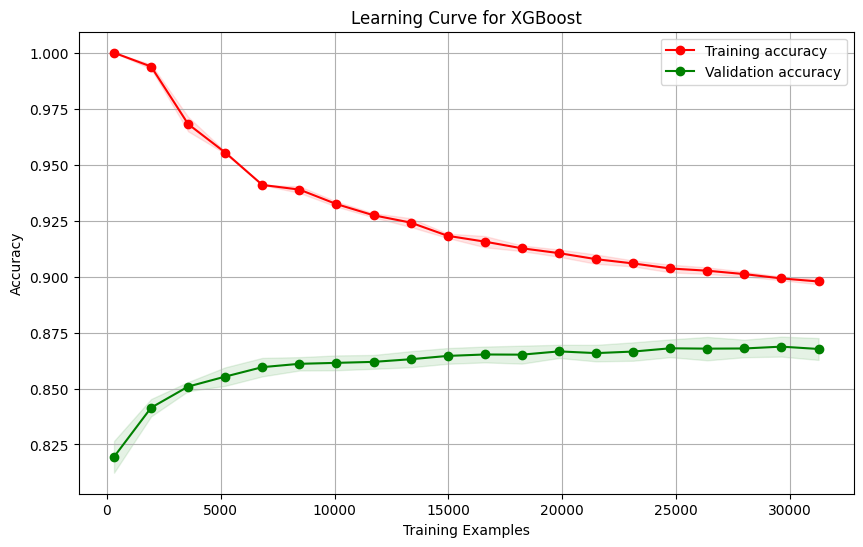

XGBoost - Training Accuracy: 0.8933, Test Accuracy: 0.8689


In [15]:
for model_name, model in models.items():
    
    plot_learning_curve(model, X_train, y_train, model_name)

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"{model_name} - Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


### 과제 2 : K-Means를 활용한 군집화

Mall_Customers 데이터를 활용해 고객을 군집화해봅시다!

[데이터 필드 설명]
- `CustomerID` -> 고객 ID
- `Gender` -> 성별
- `Age` -> 연령
- `Annual Income` -> 고객의 연간 수입
- `Spending Score` -> 상점에서 고객에게 부여한 소비 점수


In [16]:
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [17]:
data = data.drop('CustomerID', axis=1)
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

X = data.values

#### (1) Sklearn의 KMeans로 군집화하기

#####  a. 최적의 K 값 찾기

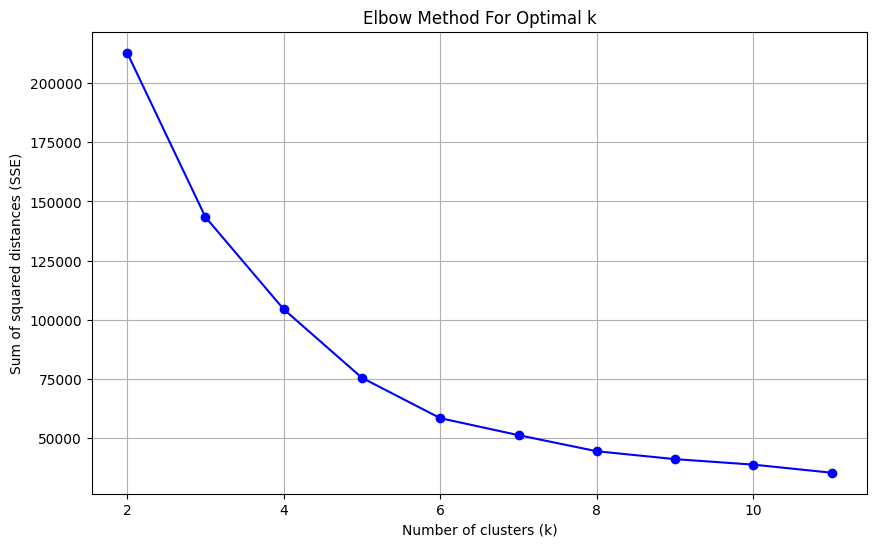

In [18]:
elbow_method(X)

In [19]:
k =  3

"""
SSE가 급격하게 떨어진 지점이기 때문에 3으로 설정함
"""

'\nSSE가 급격하게 떨어진 지점이기 때문에 3으로 설정함\n'

#####  b. Scikit-learn을 활용한 KMeans 클러스터링

In [20]:
# Scikit-learn K-Means 클러스터링

kmeans = KMeans(n_clusters=k, init='random')
kmeans.fit(X)

sklearn_labels = kmeans.labels_
sklearn_centroids = kmeans.cluster_centers_

#### (2) K-Means 직접 구현하기

scikit-learn과 같은 외부 라이브러리 없이 파이썬 내장 함수와 라이브러리만으로 K-menas 알고리즘을 직접 구현해봅시다.

In [21]:
from typing import List
import numpy as np

class K_Means:
    def __init__(self, k: int, data: np.ndarray) -> None:
        self.k: int = k
        self.data: np.ndarray = data
        self.N: int = len(data)
        self.centroids: np.ndarray = []
        self.cluster: np.ndarray = np.zeros(self.N, dtype=int)
        self._initialize_centroids()

    def _initialize_centroids(self) -> None:
        indices: np.ndarray = np.random.choice(self.N, self.k, replace=False)
        self.centroids = self.data[indices]

    def distance(self, I: np.ndarray, J: np.ndarray) -> float:
        return np.sqrt(np.sum((I - J) ** 2))

    def _assign_clusters(self) -> None:
        for i in range(self.N):
            dist: List[float] = [self.distance(self.data[i], centroid) for centroid in self.centroids]
            self.cluster[i] = np.argmin(dist)

    def _update_centroids(self) -> None:
        clusters: List[np.ndarray] = [[] for _ in range(self.k)]
        for i in range(self.N):
            clusters[int(self.cluster[i])].append(self.data[i])
        for i in range(self.k):
            if clusters[i]:
                clusters[i] = np.array(clusters[i])
                self.centroids[i] = np.mean(clusters[i], axis=0)

    def clustering(self, max_iterations: int = 100) -> np.ndarray:
        for _ in range(max_iterations):
            old_cluster: np.ndarray = np.array(self.cluster)
            self._assign_clusters()
            self._update_centroids()
            if np.array_equal(old_cluster, self.cluster):
                break
        return self.cluster

In [22]:
# 직접 만든 K-Means 클러스터링 수행
custom_kmeans = K_Means(k, X)
custom_labels = custom_kmeans.clustering()
custom_centroids = custom_kmeans.centroids

#### (3) 군집화 결과 시각화

군집화 결과를 시각화 해 직접 구현한 K-means와 Scikit-learn에서 제공하는 KMeans의 군집화 결과를 비교해봅시다.

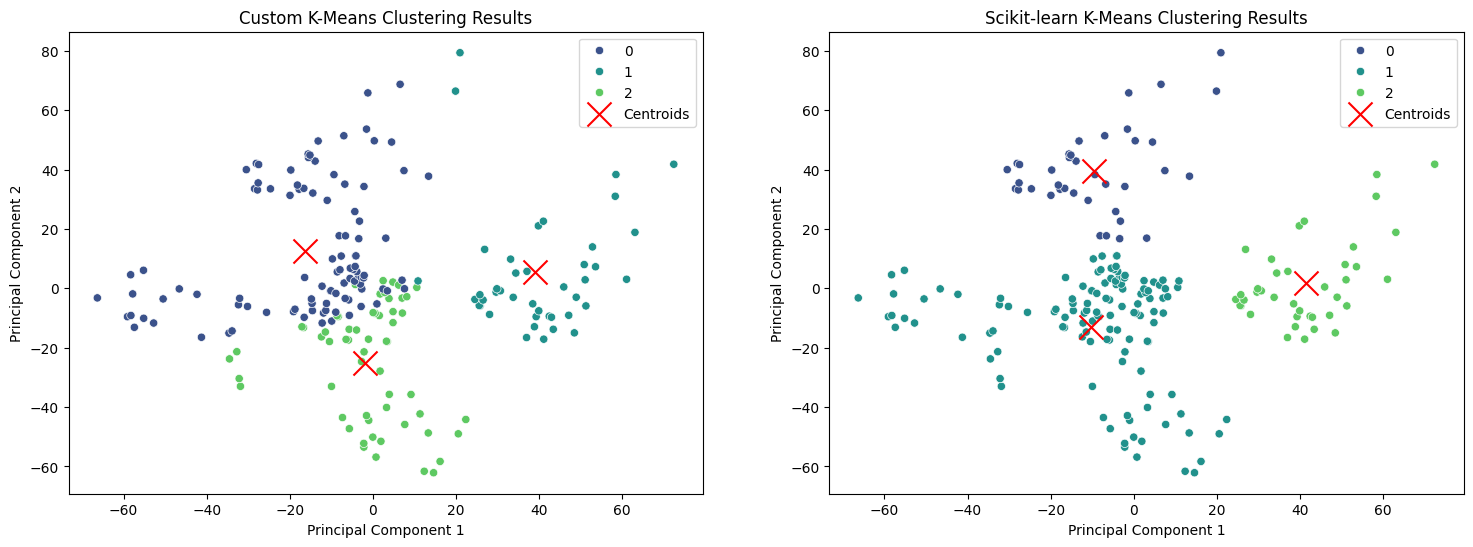

In [23]:
plot_kmeans_comparison(X, custom_labels, custom_centroids,sklearn_labels, sklearn_centroids, k )